In [1]:
%run -i writefile2.py

In [76]:
%%writefile2 --name server.py

from flask import Flask, render_template, send_from_directory
from flask_socketio import SocketIO
from io import StringIO
import os
import pandas as pd
import numpy as np
import require
import functools
import matplotlib.pyplot as plt
data_for_country = require.single( "data_for_country" )
categorical_to_dummy = require.single( "categorical_to_dummy" )
crop_to_valid_range = require.single( "crop_to_valid_range" )

app = Flask( __name__, static_folder = "static", static_url_path = '' )
socketio = SocketIO(app)

@functools.cache
def load_data( country ):

    log( f"loading data for { country }" )
    return data_for_country.get_result( country, categorical_as_dummy = False )

@app.route('/')
def serve_index():
    return send_from_directory('static', 'index.html')

@functools.cache
def read_legend( column ):

    with open( f'legend/{ column }', "r" ) as file: 
        
        text = file.read( )

    data = {}
    lines = text.strip().split('\n')
    for line in lines:
        if '-' in line:
            key, value = line.split('-', 1)  # 1 is the maxsplit parameter.
            data[key.strip()] = value.strip()
    return data
    

@socketio.event
def get_columns( ):

    df = load_data( "Germany" )
    return [ dict( 
        name = c, 
        is_measure = i >= 3,
        is_categorical = i >= 3 and not c.startswith( "new" ),
        n_categories = [ 3, 4, 4, 4 ][ i - 5 ] if i >= 3 and not c.startswith( "new" ) else 0,
        legend = read_legend( c ) if i >= 3 and not c.startswith( "new" ) else { }) for i, c in enumerate( df.columns )]
        

@socketio.event
def get_countries( ):
    
    return [ "Germany", "Switzerland", "Italy", "France", "Belgium", "United States", "Spain", "United Kingdom", "Malaysia", "South Korea", "Chile" ]

@socketio.event
@functools.cache
def get_data( country ):

    df = load_data( country ).copy( )
    fill_df( df )
    return df_to_csvs( df )

def df_to_csvs( df ):

    def to_csv( s ):

        s.name = "close"
        return s.to_csv( )

    return { c: to_csv( df[ c ]) for c in df.columns }

def csvs_to_df( csvs ):

    df = pd.DataFrame( )
    for col in csvs:

        parsed = pd.read_csv(StringIO(csvs[ col ]), index_col = "date", parse_dates = True, low_memory = False )
        df[ col ] = parsed[ "close" ]
        df.index = parsed.index

    return df

@functools.cache
def train_model( method ):

    if method == "belief_ensemble":

        train_ensemble_node = require.single( "train_ensemble" )
        return train_ensemble_node.get_result( )

def find_first_different_index( df1, df2 ):

    # create a dataframe of True/False values
    diff = ( df1 - df2 ).abs( ).to_numpy( )
    cumsum = diff.sum( axis = 1 ).cumsum( )
    cumsum_diff = np.pad(np.diff( cumsum ), (0, 1), 'constant') 
    changed_too_much = ( cumsum > 100 )
    
    # Find the first index where they differ too much
    first_diff_index = changed_too_much.argmax( ) if changed_too_much.any( ) else None

    plt.clf( )
    plt.plot( cumsum )
    
    if first_diff_index:
        
        plt.axvline( x = first_diff_index, color = "r" )
        
    plt.savefig( "cumsum.png" )

    plt.clf( )
    plt.plot( cumsum_diff )

    if first_diff_index:
        
        plt.axvline( x = first_diff_index, color = "r" )
        
    plt.savefig( "cumsum_diff.png" )
    
    log( f"first_diff_index { first_diff_index }" )
    return first_diff_index

def fill_df( df ):

    df.fillna( axis = 0, method = "ffill", inplace = True )
    df.fillna( axis = 0, method = "bfill", inplace = True )
    assert not df.isna( ).any( ).any( )

@socketio.event
def predict( args ):

    csvs, country = args
    method = "belief_ensemble"
    
    df = categorical_to_dummy( csvs_to_df( csvs ))
    assert not df.isna( ).any( ).any( )
        
    reference = categorical_to_dummy( csvs_to_df( get_data( country )))
    assert not reference.isna( ).any( ).any( )
    assert df.columns.tolist( ) == reference.columns.tolist( )
    
    log( "making predictions..." )
    model = train_model( method )
    start = find_first_different_index( df, reference )

    # no prediction necessary
    if start is None:

        log( "nothing to be done" )
        return [ df_to_csvs( df ), None ]

    else:

        df_pred = model.predict_replace( df, start = start )
        df_pred.iloc[ :start ] = df.iloc[ :start ]
        assert df_pred.shape == df.shape
        assert df_pred.columns.tolist( ) == reference.columns.tolist( )
        assert df_pred.isna( ).any( ).any( )
        
        log( "done" )
        return [ df_to_csvs( df_pred ), str( start )]

def log( * args ):

    print( * args )
    socketio.emit( "log", * args )
    socketio.sleep( 0 ) #force immediate send

def main( ):

    # preheat
    train_model( "belief_ensemble" )
    load_data( "Germany" )
    
    try:

        log( "running..." )
        log( "http://localhost:8080" )
        socketio.run( app, port = 8080, host = "0.0.0.0" )    

    except:
        
        print( "done." )

if "is_server" in os.environ:

    main( )

3900.0
0.0
12


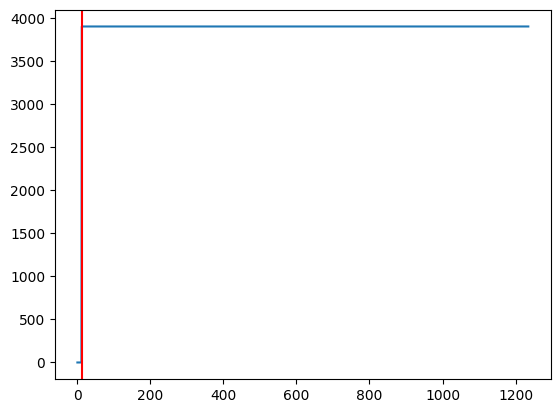

In [60]:
country = "Germany"
df = load_data( country ).copy( )
fill_df( df )
df.iloc[ 12, 0 ] = 3900
csvs = df_to_csvs( df )



df = categorical_to_dummy( csvs_to_df( csvs ))
assert not df.isna( ).any( ).any( )
    
reference = categorical_to_dummy( csvs_to_df( get_data( country )))
assert not reference.isna( ).any( ).any( )
assert df.columns.tolist( ) == reference.columns.tolist( )

df1 = df
df2 = reference


print( df1.iloc[ 12, 0 ])
print( df2.iloc[ 12, 0 ])

diff = ( df1 - df2 ).abs( ).to_numpy( )
cumsum = diff.sum( axis = 1 ).cumsum( )
changed_to_much = cumsum > 10

# Find the first index where they differ
first_diff_index = changed_to_much.argmax( ) if changed_to_much.any( ) else None
print( first_diff_index )

plt.plot( cumsum )
plt.axvline( x = first_diff_index, color = "r" )
#plt.savefig( "cumsum.png" )

#predict([ csvs, country ])